<a href="https://colab.research.google.com/github/sharathchandran2001/ai_ml_fusion_stock_prediction/blob/main/ml_multi_output_stock_prediction_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Progressive Learning Concepts:

Base Multi-Output Regressor → captures linear patterns between features and dual targets (price + volume).

Feature Engineering → adds domain context (returns, volatility), boosting explainability and predictive power.

XGBoost + Tuning → introduces nonlinearity, feature interactions, and regularization, yielding higher R² and lower MSE.

Step 1: Setup and Install Dependencies

In [ ]:
!pip install xgboost scikit-learn pandas matplotlib yfinance --quiet


Step 2: Import Libraries

In [ ]:
# =============================================
# STEP 1: Import Libraries
# =============================================
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# For display
import warnings
warnings.filterwarnings('ignore')


Step 3: Paste the Dataset (No Upload Needed)

We’ll use a small sample dataset containing Apple (AAPL) and Tesla (TSLA) daily data.

In [ ]:
# =============================================
# STEP 2: Paste Your CSV Data Here
# =============================================

csv_data = """Ticker,Date,Open,High,Low,Close,Volume
AAPL,2024-01-01,180,182,178,181,51000000
AAPL,2024-01-02,181,183,179,182,52000000
AAPL,2024-01-03,182,184,180,183,50000000
AAPL,2024-01-04,183,185,181,184,51500000
AAPL,2024-01-05,184,186,182,185,53000000
AAPL,2024-01-06,185,187,183,186,54000000
AAPL,2024-01-07,186,188,184,187,54500000
AAPL,2024-01-08,187,189,185,188,55500000
AAPL,2024-01-09,188,190,186,189,56000000
AAPL,2024-01-10,189,191,187,190,57000000
MSFT,2024-01-01,340,345,338,343,30000000
MSFT,2024-01-02,343,347,341,346,31000000
MSFT,2024-01-03,346,350,344,348,30500000
MSFT,2024-01-04,348,352,346,350,31500000
MSFT,2024-01-05,350,353,348,351,32000000
MSFT,2024-01-06,351,355,349,354,32500000
MSFT,2024-01-07,354,357,352,356,33000000
MSFT,2024-01-08,356,359,354,358,34000000
MSFT,2024-01-09,358,362,356,360,34500000
MSFT,2024-01-10,360,363,358,362,35000000
"""

# Read into DataFrame
df = pd.read_csv(StringIO(csv_data))
df.head()


,Ticker,Date,Open,High,Low,Close,Volume
0,AAPL,2024-01-01,180,182,178,181,51000000
1,AAPL,2024-01-02,181,183,179,182,52000000
2,AAPL,2024-01-03,182,184,180,183,50000000
3,AAPL,2024-01-04,183,185,181,184,51500000
4,AAPL,2024-01-05,184,186,182,185,53000000


In [ ]:
# =============================================
# STEP 3: Feature Engineering - Add Derived Targets
# =============================================
# Compute next-day close and next-day volume (multi-output)
df['Close_next'] = df.groupby('Ticker')['Close'].shift(-1)
df['Volume_next'] = df.groupby('Ticker')['Volume'].shift(-1)
df.dropna(inplace=True)

print("Data prepared with targets (Close_next, Volume_next):")
df.head()


Data prepared with targets (Close_next, Volume_next):


,Ticker,Date,Open,High,Low,Close,Volume,Close_next,Volume_next
0,AAPL,2024-01-01,180,182,178,181,51000000,182.0,52000000.0
1,AAPL,2024-01-02,181,183,179,182,52000000,183.0,50000000.0
2,AAPL,2024-01-03,182,184,180,183,50000000,184.0,51500000.0
3,AAPL,2024-01-04,183,185,181,184,51500000,185.0,53000000.0
4,AAPL,2024-01-05,184,186,182,185,53000000,186.0,54000000.0


In [ ]:
# =============================================
# STEP 4: Define Features and Targets
# =============================================
features = ['Open', 'High', 'Low', 'Close', 'Volume']
targets = ['Close_next', 'Volume_next']

X = df[features]
y = df[targets]

print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)


Feature Shape: (18, 5)
Target Shape: (18, 2)


In [ ]:
# =============================================
# STEP 5: Train/Test Split and Scaling
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")


Train size: 14 | Test size: 4


In [ ]:
# =============================================
# STEP 6: Base Model — Linear Regression
# =============================================
base_model = MultiOutputRegressor(LinearRegression())
base_model.fit(X_train_scaled, y_train)
y_pred_lr = base_model.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr, multioutput='raw_values')
mse_lr = mean_squared_error(y_test, y_pred_lr, multioutput='raw_values')

print("🔹 Base Linear Regression Results:")
for i, t in enumerate(targets):
    print(f"{t}: R2 = {r2_lr[i]:.4f}, MSE = {mse_lr[i]:.4f}")


🔹 Base Linear Regression Results:
Close_next: R2 = 0.9991, MSE = 0.0090
Volume_next: R2 = 0.6193, MSE = 2635067188454.0469


In [ ]:
# =============================================
# STEP 7: Feature Engineering — Add Return & Volatility
# =============================================
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Volatility'] = df.groupby('Ticker')['Close'].rolling(window=3).std().reset_index(level=0, drop=True)
df.dropna(inplace=True)

features_fe = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Volatility']
targets = ['Close_next', 'Volume_next']

X = df[features_fe]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

fe_model = MultiOutputRegressor(LinearRegression())
fe_model.fit(X_train_scaled, y_train)
y_pred_fe = fe_model.predict(X_test_scaled)

r2_fe = r2_score(y_test, y_pred_fe, multioutput='raw_values')
mse_fe = mean_squared_error(y_test, y_pred_fe, multioutput='raw_values')

print("🔹 After Feature Engineering (Linear Regression):")
for i, t in enumerate(targets):
    print(f"{t}: R2 = {r2_fe[i]:.4f}, MSE = {mse_fe[i]:.4f}")


🔹 After Feature Engineering (Linear Regression):
Close_next: R2 = 0.9994, MSE = 4.1588
Volume_next: R2 = 0.9997, MSE = 18789163877.2009


In [ ]:
# =============================================
# STEP 8: XGBoost + Hyperparameter Tuning
# =============================================
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_multi = MultiOutputRegressor(GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1, scoring='r2'))
xgb_multi.fit(X_train_scaled, y_train)

best_models = [est.best_estimator_ for est in xgb_multi.estimators_]
y_pred_xgb = xgb_multi.predict(X_test_scaled)

r2_xgb = r2_score(y_test, y_pred_xgb, multioutput='raw_values')
mse_xgb = mean_squared_error(y_test, y_pred_xgb, multioutput='raw_values')

print("🔹 After XGBoost + Hyperparameter Tuning:")
for i, t in enumerate(targets):
    print(f"{t}: R2 = {r2_xgb[i]:.4f}, MSE = {mse_xgb[i]:.4f}")


🔹 After XGBoost + Hyperparameter Tuning:
Close_next: R2 = 0.9783, MSE = 142.8882
Volume_next: R2 = 0.9841, MSE = 1180541517824.0000


In [ ]:
# =============================================
# STEP 9: Results Comparison Summary
# =============================================

summary = pd.DataFrame({
    'Model Stage': ['Linear Regression', 'After Feature Engineering', 'XGBoost + Tuning'],
    'R2_Close_next': [r2_lr[0], r2_fe[0], r2_xgb[0]],
    'R2_Volume_next': [r2_lr[1], r2_fe[1], r2_xgb[1]],
    'MSE_Close_next': [mse_lr[0], mse_fe[0], mse_xgb[0]],
    'MSE_Volume_next': [mse_lr[1], mse_fe[1], mse_xgb[1]],
})

print("\n📊 Model Performance Progression:\n")
display(summary)



📊 Model Performance Progression:



,Model Stage,R2_Close_next,R2_Volume_next,MSE_Close_next,MSE_Volume_next
0,Linear Regression,0.999123,0.619313,0.008986,2.635067e+12
1,After Feature Engineering,0.999368,0.999747,4.158818,1.878916e+10
2,XGBoost + Tuning,0.978274,0.984130,142.888153,1.180542e+12


In [ ]:
# =============================================
# STEP 10: Predict on New Data
# =============================================

sample_input = pd.DataFrame({
    'Open': [190],
    'High': [193],
    'Low': [188],
    'Close': [191],
    'Volume': [58000000],
    'Return': [0.01],
    'Volatility': [0.5]
})

sample_scaled = scaler.transform(sample_input)
predicted = xgb_multi.predict(sample_scaled)
print("\nPredicted Next-Day [Close, Volume]:", predicted[0])



Predicted Next-Day [Close, Volume]: [2.2120552e+02 5.6765444e+07]


✅ Raw Data Loaded:
          Date  Open  High  Low  Close    Volume
0  2024-07-01   180   185  178    183  50000000
1  2024-07-02   183   188  182    187  52000000
2  2024-07-03   187   189  185    188  53000000
3  2024-07-04   188   190  186    189  54000000
4  2024-07-05   189   191  188    190  56000000 

📊 Evaluation Metrics:
R² (Close):  -6.433
R² (Volume): -5.001
RMSE (Close): 4.03
RMSE (Volume): 2738809.90
MAE (Close): 3.75
MAE (Volume): 2500216.00



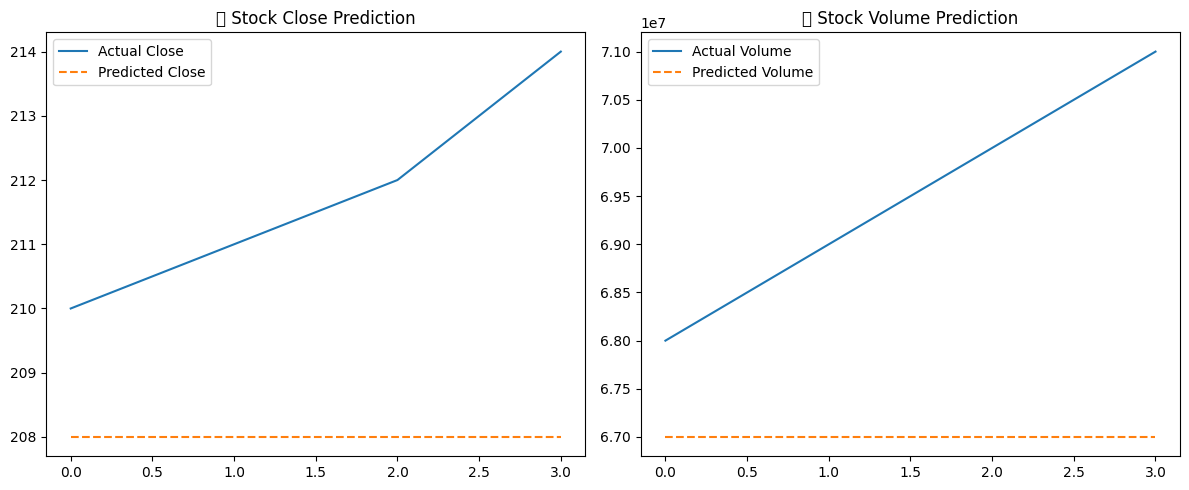

🔮 Predicted Next-Day [Close, Volume]: [2.0799863e+02 6.6999784e+07]


In [ ]:
# ======================================================
# 📘 Multi-Output Stock Price & Volume Predictor (All-in-One)
# ======================================================
# Author: Your Name
# Objective:
#   Train & evaluate a multi-output XGBoost model predicting
#   next-day Stock Close & Volume from past-day features.
# ======================================================

# !pip install xgboost pandas scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from io import StringIO

# ======================================================
# Step 1️⃣: Inline CSV Data (20 Rows)
# ======================================================
csv_text = """Date,Open,High,Low,Close,Volume
2024-07-01,180,185,178,183,50000000
2024-07-02,183,188,182,187,52000000
2024-07-03,187,189,185,188,53000000
2024-07-04,188,190,186,189,54000000
2024-07-05,189,191,188,190,56000000
2024-07-06,190,194,189,193,57000000
2024-07-07,193,195,191,192,58000000
2024-07-08,192,196,191,194,59000000
2024-07-09,194,198,193,197,60000000
2024-07-10,197,199,195,198,61000000
2024-07-11,198,201,197,200,62000000
2024-07-12,200,203,198,202,63000000
2024-07-13,202,204,201,203,64000000
2024-07-14,203,206,202,205,65000000
2024-07-15,205,207,204,206,66000000
2024-07-16,206,209,205,208,67000000
2024-07-17,208,211,207,210,68000000
2024-07-18,210,212,208,211,69000000
2024-07-19,211,213,209,212,70000000
2024-07-20,212,215,210,214,71000000
"""
df = pd.read_csv(StringIO(csv_text))
print("✅ Raw Data Loaded:\n", df.head(), "\n")

# ======================================================
# Step 2️⃣: Feature Engineering
# ======================================================
df['Close_lag1'] = df['Close'].shift(1)
df['Volume_lag1'] = df['Volume'].shift(1)
df['MA_Close_3'] = df['Close'].rolling(3).mean()
df['MA_Vol_3'] = df['Volume'].rolling(3).mean()
df = df.dropna().reset_index(drop=True)

features = ['Open', 'High', 'Low', 'Close_lag1', 'Volume_lag1', 'MA_Close_3', 'MA_Vol_3']
target = ['Close', 'Volume']

X = df[features]
y = df[target]

# ======================================================
# Step 3️⃣: Train/Test Split & Scaling
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======================================================
# Step 4️⃣: Train XGBoost Multi-Output Regressor
# ======================================================
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model = MultiOutputRegressor(xgb)
model.fit(X_train_scaled, y_train)

# ======================================================
# Step 5️⃣: Evaluate Model
# ======================================================
y_pred = model.predict(X_test_scaled)

r2_close = r2_score(y_test['Close'], y_pred[:, 0])
r2_vol = r2_score(y_test['Volume'], y_pred[:, 1])
mse_close = mean_squared_error(y_test['Close'], y_pred[:, 0])
mse_vol = mean_squared_error(y_test['Volume'], y_pred[:, 1])
rmse_close = np.sqrt(mse_close)
rmse_vol = np.sqrt(mse_vol)
mae_close = mean_absolute_error(y_test['Close'], y_pred[:, 0])
mae_vol = mean_absolute_error(y_test['Volume'], y_pred[:, 1])

print("📊 Evaluation Metrics:")
print(f"R² (Close):  {r2_close:.3f}")
print(f"R² (Volume): {r2_vol:.3f}")
print(f"RMSE (Close): {rmse_close:.2f}")
print(f"RMSE (Volume): {rmse_vol:.2f}")
print(f"MAE (Close): {mae_close:.2f}")
print(f"MAE (Volume): {mae_vol:.2f}\n")

# ======================================================
# Step 6️⃣: Visualization
# ======================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test['Close'].values, label="Actual Close")
plt.plot(y_pred[:,0], label="Predicted Close", linestyle='--')
plt.title("📈 Stock Close Prediction")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test['Volume'].values, label="Actual Volume")
plt.plot(y_pred[:,1], label="Predicted Volume", linestyle='--')
plt.title("📊 Stock Volume Prediction")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# Step 7️⃣: Predict Next-Day Close & Volume
# ======================================================
latest = X_test_scaled[-1].reshape(1, -1)
pred_next = model.predict(latest)[0]
print(f"🔮 Predicted Next-Day [Close, Volume]: {pred_next}")


### Medium version

In [ ]:
# ==========================
# Multi-Output Stock Predictor (Open, High, Close, Volume)
# ==========================

import pandas as pd
from io import StringIO
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb

# === Step 1: Paste CSV Data ===
csv_data = """Date,Open,High,Low,Close,Volume
2024-01-01,100,105,99,104,50000
2024-01-02,104,107,101,106,52000
2024-01-03,106,108,103,107,51000
2024-01-04,107,110,104,109,53000
2024-01-05,109,111,107,110,54000
2024-01-06,110,113,108,112,56000
2024-01-07,112,115,109,113,55000
2024-01-08,113,116,111,115,57000
2024-01-09,115,118,113,117,58000
2024-01-10,117,120,115,119,59000
2024-01-11,119,122,117,121,60000
2024-01-12,121,123,119,122,61000
2024-01-13,122,125,120,124,62000
2024-01-14,124,127,122,126,63000
2024-01-15,126,128,124,127,64000
2024-01-16,127,129,125,128,65000
2024-01-17,128,130,126,129,66000
2024-01-18,129,132,127,131,67000
2024-01-19,131,133,129,132,68000
2024-01-20,132,135,130,134,69000
"""

df = pd.read_csv(StringIO(csv_data))

# === Step 2: Create Next-Day Targets ===
for col in ['Open', 'High', 'Close', 'Volume']:
    df[f'{col}_next'] = df[col].shift(-1)
df.dropna(inplace=True)

# === Step 3: Feature Engineering ===
df['Price_Change'] = df['Close'] - df['Open']
df['Volatility'] = df['High'] - df['Low']
df['Rolling_Avg_Close'] = df['Close'].rolling(3).mean().fillna(df['Close'].mean())

# === Step 4: Features and Targets ===
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'Volatility', 'Rolling_Avg_Close']
targets = ['Open_next', 'High_next', 'Close_next', 'Volume_next']

X = df[features]
y = df[targets]

# === Step 5: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Scale ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Step 7: Baseline Linear Regression ===
lr_multi = MultiOutputRegressor(LinearRegression())
lr_multi.fit(X_train_scaled, y_train)
y_pred_lr = lr_multi.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr, multioutput='uniform_average')
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print("📊 Baseline Linear Regression")
print(f"R²: {r2_lr:.4f}, MSE: {mse_lr:.4f}, RMSE: {rmse_lr:.4f}\n")

# === Step 8: XGBoost with Hyperparameter Tuning ===
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_multi = MultiOutputRegressor(GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2'))
xgb_multi.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_multi.predict(X_test_scaled)

r2_xgb = r2_score(y_test, y_pred_xgb, multioutput='uniform_average')
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print("🚀 XGBoost with Hyperparameter Tuning")
print(f"R²: {r2_xgb:.4f}, MSE: {mse_xgb:.4f}, RMSE: {rmse_xgb:.4f}\n")

# === Step 9: Predict for Last Row ===
last_row_scaled = scaler.transform(X.iloc[[-1]])
predicted_next = xgb_multi.predict(last_row_scaled)[0]
print(f"🔮 Predicted Next-Day [Open, High, Close, Volume]: {predicted_next}")


📊 Baseline Linear Regression
R²: 0.8808, MSE: 1213811.1688, RMSE: 1101.7310

🚀 XGBoost with Hyperparameter Tuning
R²: 0.8610, MSE: 715297.0000, RMSE: 845.7523

🔮 Predicted Next-Day [Open, High, Close, Volume]: [  131.1991    134.10886   133.10886 68439.35   ]


📊 Baseline Linear Regression
R²: 0.8383, MSE: 19519447185626.9141, RMSE: 4418081.8446

🚀 XGBoost with Hyperparameter Tuning
R²: 0.8272, MSE: 20801076068352.0000, RMSE: 4560819.6707

🔮 Predicted Next-Day [Open, High, Close, Volume]: [6.1592094e+01 6.2320892e+01 5.9853848e+01 3.6278252e+07]



/tmp/ipython-input-3217148425.py:376: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


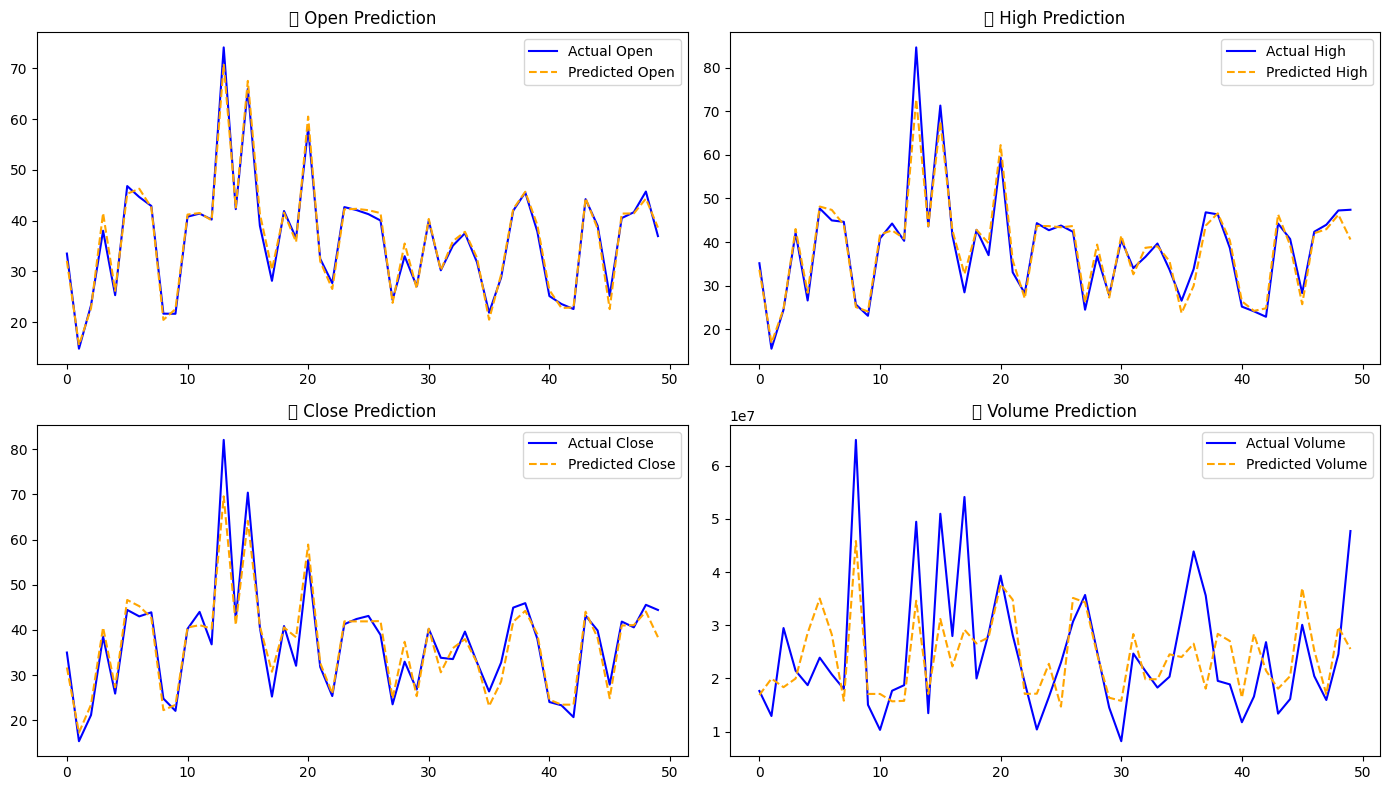

In [ ]:
# ==========================
# Multi-Output Stock Predictor (Open, High, Close, Volume)
# ==========================

import pandas as pd
from io import StringIO
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# === Step 1: Paste CSV Data ===
# csv_data = """Date,Open,High,Low,Close,Volume
# 2024-01-01,100,105,99,104,50000
# 2024-01-02,104,107,101,106,52000
# 2024-01-03,106,108,103,107,51000
# 2024-01-04,107,110,104,109,53000
# 2024-01-05,109,111,107,110,54000
# 2024-01-06,110,113,108,112,56000
# 2024-01-07,112,115,109,113,55000
# 2024-01-08,113,116,111,115,57000
# 2024-01-09,115,118,113,117,58000
# 2024-01-10,117,120,115,119,59000
# 2024-01-11,119,122,117,121,60000
# 2024-01-12,121,123,119,122,61000
# 2024-01-13,122,125,120,124,62000
# 2024-01-14,124,127,122,126,63000
# 2024-01-15,126,128,124,127,64000
# 2024-01-16,127,129,125,128,65000
# 2024-01-17,128,130,126,129,66000
# 2024-01-18,129,132,127,131,67000
# 2024-01-19,131,133,129,132,68000
# 2024-01-20,132,135,130,134,69000
# """

# df = pd.read_csv(StringIO(csv_data))


#  ============================  try IONQ ===================================
#  https://finance.yahoo.com/quote/IONQ/history/

csv_data = """Date,Open,High,Low,Close,Volume
2024-10-25,15.8,17.05,15.71,16.96,25259600
2024-10-28,17.52,18.2,16.55,17.81,31529500
2024-10-29,17.5,17.8,15.73,16.74,32312900
2024-10-30,15.76,17.55,15.76,16.87,23685200
2024-10-31,16.71,16.98,14.76,15.03,22506900
2024-11-01,15.27,15.51,14.53,14.85,15847000
2024-11-04,14.9,15.11,14.15,14.37,12424200
2024-11-05,14.79,15.55,14.63,15.35,12942800
2024-11-06,16.73,16.83,15.85,16.45,20834500
2024-11-07,16.43,22.62,16.29,22.11,70733400
2024-11-08,21.69,25.68,21.31,24.79,64845200
2024-11-11,24.39,24.49,21.3,23.52,35693700
2024-11-12,22,25.44,22,23.01,28019200
2024-11-13,23.88,27.65,23.67,26.76,41306100
2024-11-14,27.9,28.05,24.87,26.16,35122500
2024-11-15,26.29,29.48,25.03,29.14,37576000
2024-11-18,28.15,28.47,22.27,25.23,54116400
2024-11-19,25.2,28.3,24.87,27.89,30086600
2024-11-20,27.91,30.5,27.43,28.86,28874800
2024-11-21,28.8,33.8,28.48,32.78,43881800
2024-11-22,32.49,33.07,30.3,31.8,28146300
2024-11-25,33.93,35.24,30.46,30.88,31379300
2024-11-26,30.5,32.86,29.7,30.65,22521800
2024-11-27,31.1,32.37,28.32,32.21,24277900
2024-11-29,32.21,37.28,31.96,36.5,23227400
2024-12-02,36.54,37,31.77,32.06,28440400
2024-12-03,31.8,33.68,30.82,32.79,20329100
2024-12-04,32.68,34.95,31.17,33.42,17219600
2024-12-05,33.95,37.64,32.65,35.95,28954000
2024-12-06,36.31,38.45,34.9,37.97,19783600
2024-12-09,38,38.25,34.16,34.24,22414900
2024-12-10,33,36.75,32.63,32.97,25017800
2024-12-11,32.99,32.99,28.04,29.83,36443900
2024-12-12,29.36,32.78,28.94,29.99,21879500
2024-12-13,30.23,34.03,29.52,33.83,24677300
2024-12-16,32.47,42.81,32.39,41.81,42539400
2024-12-17,41.64,43.94,39.25,43.84,31560500
2024-12-18,41.65,44.99,37,37.5,37488600
2024-12-19,40.71,42.4,36.54,37.76,27705800
2024-12-20,36.96,47.41,36.7,44.42,47711400
2024-12-23,45.33,45.5,41.3,41.32,27057200
2024-12-24,41.99,45.4,39.84,44.58,18418400
2024-12-26,44.5,48.56,42.56,48.24,24726600
2024-12-27,46.87,48.25,44.5,45.48,22491400
2024-12-30,44.6,45.79,41.51,44.29,17610900
2024-12-31,44.52,45.14,40.9,41.77,15311400
2025-01-02,41.28,43.79,38.46,43.1,22986200
2025-01-03,43.1,47.91,43,47.77,28235500
2025-01-06,48.3,51.66,47.13,51.07,23299900
2025-01-07,51.28,54.74,48.73,49.59,27090300
2025-01-08,38.75,39,25.92,30.25,128343800
2025-01-10,31.99,33.98,28.51,32.33,69769800
2025-01-13,29.55,32.83,27.16,27.86,52751700
2025-01-14,28.2,30.2,26.63,29.51,43673200
2025-01-15,32.78,40.5,32.41,39.39,74872100
2025-01-16,36.86,42,36.13,41.55,46324600
2025-01-17,40.03,42.35,38.77,38.89,30697700
2025-01-21,39.19,45.56,38.8,45.31,35231900
2025-01-22,45.24,45.35,40.94,42.04,26440200
2025-01-23,41.44,43.94,40.33,41.35,17140800
2025-01-24,41.69,44.23,40.51,40.76,19665900
2025-01-27,38.02,42.12,37,38.54,21461100
2025-01-28,40.01,40.36,35.75,38.86,15725200
2025-01-29,39.26,40.6,38.39,39.54,13098600
2025-01-30,40.45,41.68,38.23,38.81,12505500
2025-01-31,38.96,42.98,38.8,39.49,20046600
2025-02-03,37.4,42.38,37.21,41.47,16578800
2025-02-04,41.89,44.59,41.43,41.86,16434500
2025-02-05,42.27,43.59,39.65,42.32,13473000
2025-02-06,42.67,44.34,40.65,41.27,10405900
2025-02-07,41.66,43.97,40.05,40.57,15951700
2025-02-10,39.49,42.85,39.18,41.07,13666900
2025-02-11,41.8,42.49,37.55,37.7,15568800
2025-02-12,38,39.33,37.51,38,11894500
2025-02-13,38.58,38.85,36.52,38.65,14220200
2025-02-14,38.4,38.58,37.04,37.46,8178200
2025-02-18,36,36.32,32.82,33.94,20116100
2025-02-19,33.33,35.93,32.34,34.14,20531200
2025-02-20,35.64,35.71,32.84,33.75,13058700
2025-02-21,34.81,35.5,31.36,31.74,15788800
2025-02-24,31.16,32.54,30.01,31.24,12451800
2025-02-25,30.88,31.11,28.12,29.73,13278400
2025-02-26,30.78,31.07,29.55,29.93,13883600
2025-02-27,28.04,28.99,24.33,24.91,34732800
2025-02-28,24.04,25.62,23.01,24.57,21996100
2025-03-03,25.32,25.58,22.65,23.11,18253700
2025-03-04,21.45,23.2,20.84,22.35,21074800
2025-03-05,22.91,23.2,21.66,22.63,16067800
2025-03-06,21.99,22.06,20.32,20.48,16639300
2025-03-07,20.51,21.29,19.92,20.55,16189200
2025-03-10,20,20.11,17.93,18.27,15686800
2025-03-11,18.38,19.18,17.88,18.7,17836200
2025-03-12,20.27,22.19,19.59,21.82,27255100
2025-03-13,21.7,22.57,20.57,21.37,32423200
2025-03-14,22.13,25.24,22.06,25,37795900
2025-03-17,24.98,25.5,24.03,24.93,30552900
2025-03-18,23.65,24.46,22.64,22.68,20876300
2025-03-19,23.59,24.12,22.18,23.3,16600500
2025-03-20,23.33,24.5,20.61,21.14,29478500
2025-03-21,20.96,22.72,20.86,22.26,21965900
2025-03-24,23.23,26.32,23.08,26.12,34724200
2025-03-25,25.77,26.19,25.04,25.55,17186900
2025-03-26,26.73,27.83,24.66,24.8,29897400
2025-03-27,24.09,25.2,23.44,23.65,14119000
2025-03-28,23.66,23.66,21.92,22.85,15453500
2025-03-31,21.67,23.1,21.5,22.07,15046800
2025-04-01,24.31,24.62,22.22,23.19,22958100
2025-04-02,23.08,25.83,22.69,25.05,25696300
2025-04-03,23.13,23.78,22.53,23.25,19912800
2025-04-04,22.6,22.87,19.37,20.68,26829500
2025-04-07,19.61,24,18.81,22.75,29250700
2025-04-08,24.05,24.6,20.65,21.28,26233100
2025-04-09,21.88,26.56,21.36,26.37,31936100
2025-04-10,25.33,26.61,24.45,25.89,18742100
2025-04-11,26.24,27.25,25.37,26.09,15810600
2025-04-14,27.7,28.25,24.75,25.35,19201300
2025-04-15,25.59,26.08,24.67,25.4,9735200
2025-04-16,24.45,25.36,23.8,24.57,9711300
2025-04-17,24.93,25.87,24.48,25.74,10178700
2025-04-21,25.16,25.2,23.49,24.03,11771300
2025-04-22,24.49,25.93,23.93,25.56,12158500
2025-04-23,27.09,27.84,26.27,26.8,14517900
2025-04-24,27,29.58,26.96,28.39,17959300
2025-04-25,28.42,31.85,27.71,28.9,27672300
2025-04-28,29.29,29.96,27.27,28.7,13570800
2025-04-29,28.9,29.14,27.69,28.09,8214700
2025-04-30,26.72,27.5,26.33,27.46,9548200
2025-05-01,28.33,28.46,27.16,27.38,9987400
2025-05-02,27.8,31.33,27.65,30.92,24011700
2025-05-05,30.13,30.83,29.61,29.82,9584900
2025-05-06,28.55,29.5,27.97,29.42,10913300
2025-05-07,29.02,29.35,28.5,29.14,8906100
2025-05-08,31.74,33.5,28.11,31.84,39187700
2025-05-09,31.43,32.64,29.93,31.27,19086400
2025-05-12,33.12,33.93,31.93,32.89,16465600
2025-05-13,32.61,34.1,32.33,33.22,13943100
2025-05-14,33.7,35.29,32.75,33.41,18701800
2025-05-15,32.93,34.4,32.23,32.54,11151400
2025-05-16,33.52,35.15,32.97,34.99,17643800
2025-05-19,33.6,35.13,32.83,35.09,13255300
2025-05-20,35.89,35.99,34.19,35.31,17686200
2025-05-21,35.08,36.61,33.33,33.54,21395200
2025-05-22,33.82,48.92,33.73,45.79,105188100
2025-05-23,41.96,47.87,41.21,45.69,53827300
2025-05-27,46.55,48.08,43.6,48.04,30147600
2025-05-28,46,48.94,44.65,47.56,28831300
2025-05-29,48,48.82,42.94,43.2,25706100
2025-05-30,40.46,41.61,39.3,40.34,27156200
2025-06-02,40.01,41.07,38.35,40.57,15261800
2025-06-03,41.74,42.39,39.52,39.81,12476200
2025-06-04,40.04,40.15,37.93,39.64,12079000
2025-06-05,39.1,39.25,35.93,36.66,17201700
2025-06-06,37.67,39.95,36.8,39.02,16146100
2025-06-09,42.53,42.55,38.85,40.06,36305100
2025-06-10,40.64,44.05,39.46,39.74,31977900
2025-06-11,41.59,43.96,38.94,39.7,53397300
2025-06-12,39.49,40.86,38.62,38.71,20079600
2025-06-13,37.59,39.83,37.44,37.84,19404600
2025-06-16,37.24,39.26,36.03,38.43,29311100
2025-06-17,37.86,38.66,36.86,38.04,18889300
2025-06-18,37.52,39.67,37.31,39.63,18288700
2025-06-20,39.61,41.44,38.92,40.36,33099000
2025-06-23,38.87,41.21,37.38,41.14,24966100
2025-06-24,41.9,42.81,40.53,40.86,19999100
2025-06-25,41.72,42.13,38.06,38.11,16075700
2025-06-26,39.57,41.7,39.01,41.12,21786400
2025-06-27,41.3,41.87,38.97,40.25,21643300
2025-06-30,41.21,44.1,41.08,42.97,29526400
2025-07-01,42.37,42.67,39.72,40.1,21237900
2025-07-02,41.19,44.92,40.47,44.75,24757100
2025-07-03,44.22,45.58,43.22,44.39,13345300
2025-07-07,46.38,47.21,42.85,45.2,33850900
2025-07-08,46.65,47.88,44.68,44.97,25675900
2025-07-09,45.73,47.25,44.48,45.56,24574200
2025-07-10,45.56,46.35,44.53,45.93,19544600
2025-07-11,45,45.57,41.77,41.81,23363600
2025-07-14,42.09,42.72,41.38,42.41,16527600
2025-07-15,42.55,43.14,41.08,41.47,15889200
2025-07-16,42.25,43.67,40.84,43.54,24133200
2025-07-17,43.44,44.86,43.12,44.84,20228800
2025-07-18,44.87,47.64,44.02,46.51,25760400
2025-07-21,46.81,47.72,44.42,44.43,23907000
2025-07-22,44.52,44.54,41.29,41.94,18995700
2025-07-23,42.74,43.54,41.78,43.28,14455100
2025-07-24,42.89,44.64,42.25,43.9,18006300
2025-07-25,44.24,44.25,42.94,43.17,13392000
2025-07-28,43.92,44.53,41.44,42.34,16976700
2025-07-29,43.01,44.21,40.35,40.53,21070300
2025-07-30,40.97,41.86,39.23,39.88,17861400
2025-07-31,41.12,42.28,39.62,39.87,21572700
2025-08-01,38.94,39.19,37.25,38.12,20028200
2025-08-04,38.99,40.7,38.42,39.86,16131400
2025-08-05,40.64,42.44,40.13,42.02,22060500
2025-08-06,43.6,43.6,40.78,41.23,23969600
2025-08-07,38.98,41.58,38.61,40.49,27970400
2025-08-08,40.51,42.37,40.41,41.85,20441500
2025-08-11,41.95,46.82,41.41,44.94,35598800
2025-08-12,44.65,44.97,42.63,43,20775300
2025-08-13,43.23,43.5,40.75,41.21,20702300
2025-08-14,40.51,41.12,39.28,41.03,16638200
2025-08-15,40.78,40.83,39.42,40.23,10334800
2025-08-18,40,40.5,39.01,40.23,8204300
2025-08-19,40.22,40.29,36.58,36.8,18738400
2025-08-20,37.38,37.41,34.77,36.79,16401300
2025-08-21,37.25,37.38,36.45,37.17,10121000
2025-08-22,37.1,39.92,36.65,39.78,15199400
2025-08-25,39.7,39.82,38.53,38.68,12158700
2025-08-26,38.85,40.92,38.71,40.75,13548900
2025-08-27,41.02,42.67,40.77,41.42,17335700
2025-08-28,41.55,43.73,41.45,43.3,16109100
2025-08-29,42.55,43.27,41.81,42.74,11540600
2025-09-02,41.03,43.05,40.22,42.99,13787100
2025-09-03,42.65,43.21,40.58,40.97,10369800
2025-09-04,41.23,43.03,40.79,42.11,13213900
2025-09-05,42.46,42.73,40.51,41.8,11508900
2025-09-08,42.09,42.59,40.38,41.01,10501700
2025-09-09,41.39,44.26,41.04,44,17694900
2025-09-10,44.31,45.18,43.56,43.86,14430000
2025-09-11,44.2,47.23,43.38,47.05,21599100
2025-09-12,47.3,56.07,47.15,55.61,68818800
2025-09-15,56.88,59.89,55.95,59.11,34677000
2025-09-16,58.98,62.85,57.13,62.26,30636600
2025-09-17,63.31,66.39,61.08,65.44,49629900
2025-09-18,68.57,70.43,65.42,66.81,45892900
2025-09-19,65.98,71.3,65.64,70.41,50959400
2025-09-22,68.11,73.17,66.15,71.94,35675500
2025-09-23,74.08,76.13,71.45,75.14,40011900
2025-09-24,75.25,75.95,71.01,73.86,33075600
2025-09-25,71.16,72.29,66.91,69.43,44799700
2025-09-26,68.41,70.42,65.33,67.28,32156900
2025-09-29,68.38,68.88,63.22,64.26,27595300
2025-09-30,63.59,65,60.59,61.5,22600600
2025-10-01,61.38,64.85,60.14,63.09,33912400
2025-10-02,64.81,69.6,64.41,69.6,37383600
2025-10-03,70.59,73.76,68.35,73.28,37681800
2025-10-06,72,79.23,71.88,78.99,36301000
2025-10-07,80.96,82.97,75.48,79.23,47589100
2025-10-08,78.95,82.41,72.6,74.3,40788200
2025-10-09,74.87,78,73.65,77.5,25016200
2025-10-10,77,77.38,70.64,70.65,41146800
2025-10-13,74.11,84.64,72.8,82.09,49458800
2025-10-14,79.85,81.08,75.92,77.55,34459600
2025-10-15,79.94,80.23,70.8,72.41,31348000
2025-10-16,73.87,73.87,65.5,65.59,35988400
2025-10-17,65.4,65.72,61.21,62.94,33423300
2025-10-20,65.31,65.5,58.69,59.94,28516100
2025-10-21,60.44,60.9,57.21,59.5,26167000
2025-10-22,58.2,59.35,52.27,55.45,39326800
2025-10-23,61.1,62.93,57,59.37,65822800
2025-10-24,62.01,64.11,59.92,60.3,27401100
"""

df = pd.read_csv(StringIO(csv_data))



# === Step 2: Create Next-Day Targets ===
for col in ['Open', 'High', 'Close', 'Volume']:
    df[f'{col}_next'] = df[col].shift(-1)
df.dropna(inplace=True)

# === Step 3: Feature Engineering ===
df['Price_Change'] = df['Close'] - df['Open']
df['Volatility'] = df['High'] - df['Low']
df['Rolling_Avg_Close'] = df['Close'].rolling(3).mean().fillna(df['Close'].mean())

# === Step 4: Features and Targets ===
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'Volatility', 'Rolling_Avg_Close']
targets = ['Open_next', 'High_next', 'Close_next', 'Volume_next']

X = df[features]
y = df[targets]

# === Step 5: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Scale ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Step 7: Baseline Linear Regression ===
lr_multi = MultiOutputRegressor(LinearRegression())
lr_multi.fit(X_train_scaled, y_train)
y_pred_lr = lr_multi.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr, multioutput='uniform_average')
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print("📊 Baseline Linear Regression")
print(f"R²: {r2_lr:.4f}, MSE: {mse_lr:.4f}, RMSE: {rmse_lr:.4f}\n")

# === Step 8: XGBoost with Hyperparameter Tuning ===
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_multi = MultiOutputRegressor(GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2'))
xgb_multi.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_multi.predict(X_test_scaled)

r2_xgb = r2_score(y_test, y_pred_xgb, multioutput='uniform_average')
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print("🚀 XGBoost with Hyperparameter Tuning")
print(f"R²: {r2_xgb:.4f}, MSE: {mse_xgb:.4f}, RMSE: {rmse_xgb:.4f}\n")

# === Step 9: Predict for Last Row ===
last_row_scaled = scaler.transform(X.iloc[[-1]])
predicted_next = xgb_multi.predict(last_row_scaled)[0]
print(f"🔮 Predicted Next-Day [Open, High, Close, Volume]: {predicted_next}\n")

# === Step 🔟 Visualization ===
plt.figure(figsize=(14,8))
titles = ['Open', 'High', 'Close', 'Volume']

for i, target in enumerate(targets):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[target].values, label=f"Actual {titles[i]}", color='blue')
    plt.plot(y_pred_xgb[:, i], label=f"Predicted {titles[i]}", linestyle='--', color='orange')
    plt.title(f"📈 {titles[i]} Prediction")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
2024-10-25,15.8,17.05,15.71,16.96,25259600
2024-10-28,17.52,18.2,16.55,17.81,31529500
2024-10-29,17.5,17.8,15.73,16.74,32312900
2024-10-30,15.76,17.55,15.76,16.87,23685200
2024-10-31,16.71,16.98,14.76,15.03,22506900
2024-11-01,15.27,15.51,14.53,14.85,15847000
2024-11-04,14.9,15.11,14.15,14.37,12424200
2024-11-05,14.79,15.55,14.63,15.35,12942800
2024-11-06,16.73,16.83,15.85,16.45,20834500
2024-11-07,16.43,22.62,16.29,22.11,70733400
2024-11-08,21.69,25.68,21.31,24.79,64845200
2024-11-11,24.39,24.49,21.3,23.52,35693700
2024-11-12,22,25.44,22,23.01,28019200
2024-11-13,23.88,27.65,23.67,26.76,41306100
2024-11-14,27.9,28.05,24.87,26.16,35122500
2024-11-15,26.29,29.48,25.03,29.14,37576000
2024-11-18,28.15,28.47,22.27,25.23,54116400
2024-11-19,25.2,28.3,24.87,27.89,30086600
2024-11-20,27.91,30.5,27.43,28.86,28874800
2024-11-21,28.8,33.8,28.48,32.78,43881800
2024-11-22,32.49,33.07,30.3,31.8,28146300
2024-11-25,33.93,35.24,30.46,30.88,31379300
2024-11-26,30.5,32.86,29.7,30.65,22521800
2024-11-27,31.1,32.37,28.32,32.21,24277900
2024-11-29,32.21,37.28,31.96,36.5,23227400
2024-12-02,36.54,37,31.77,32.06,28440400
2024-12-03,31.8,33.68,30.82,32.79,20329100
2024-12-04,32.68,34.95,31.17,33.42,17219600
2024-12-05,33.95,37.64,32.65,35.95,28954000
2024-12-06,36.31,38.45,34.9,37.97,19783600
2024-12-09,38,38.25,34.16,34.24,22414900
2024-12-10,33,36.75,32.63,32.97,25017800
2024-12-11,32.99,32.99,28.04,29.83,36443900
2024-12-12,29.36,32.78,28.94,29.99,21879500
2024-12-13,30.23,34.03,29.52,33.83,24677300
2024-12-16,32.47,42.81,32.39,41.81,42539400
2024-12-17,41.64,43.94,39.25,43.84,31560500
2024-12-18,41.65,44.99,37,37.5,37488600
2024-12-19,40.71,42.4,36.54,37.76,27705800
2024-12-20,36.96,47.41,36.7,44.42,47711400
2024-12-23,45.33,45.5,41.3,41.32,27057200
2024-12-24,41.99,45.4,39.84,44.58,18418400
2024-12-26,44.5,48.56,42.56,48.24,24726600
2024-12-27,46.87,48.25,44.5,45.48,22491400
2024-12-30,44.6,45.79,41.51,44.29,17610900
2024-12-31,44.52,45.14,40.9,41.77,15311400
2025-01-02,41.28,43.79,38.46,43.1,22986200
2025-01-03,43.1,47.91,43,47.77,28235500
2025-01-06,48.3,51.66,47.13,51.07,23299900
2025-01-07,51.28,54.74,48.73,49.59,27090300
2025-01-08,38.75,39,25.92,30.25,128343800
2025-01-10,31.99,33.98,28.51,32.33,69769800
2025-01-13,29.55,32.83,27.16,27.86,52751700
2025-01-14,28.2,30.2,26.63,29.51,43673200
2025-01-15,32.78,40.5,32.41,39.39,74872100
2025-01-16,36.86,42,36.13,41.55,46324600
2025-01-17,40.03,42.35,38.77,38.89,30697700
2025-01-21,39.19,45.56,38.8,45.31,35231900
2025-01-22,45.24,45.35,40.94,42.04,26440200
2025-01-23,41.44,43.94,40.33,41.35,17140800
2025-01-24,41.69,44.23,40.51,40.76,19665900
2025-01-27,38.02,42.12,37,38.54,21461100
2025-01-28,40.01,40.36,35.75,38.86,15725200
2025-01-29,39.26,40.6,38.39,39.54,13098600
2025-01-30,40.45,41.68,38.23,38.81,12505500
2025-01-31,38.96,42.98,38.8,39.49,20046600
2025-02-03,37.4,42.38,37.21,41.47,16578800
2025-02-04,41.89,44.59,41.43,41.86,16434500
2025-02-05,42.27,43.59,39.65,42.32,13473000
2025-02-06,42.67,44.34,40.65,41.27,10405900
2025-02-07,41.66,43.97,40.05,40.57,15951700
2025-02-10,39.49,42.85,39.18,41.07,13666900
2025-02-11,41.8,42.49,37.55,37.7,15568800
2025-02-12,38,39.33,37.51,38,11894500
2025-02-13,38.58,38.85,36.52,38.65,14220200
2025-02-14,38.4,38.58,37.04,37.46,8178200
2025-02-18,36,36.32,32.82,33.94,20116100
2025-02-19,33.33,35.93,32.34,34.14,20531200
2025-02-20,35.64,35.71,32.84,33.75,13058700
2025-02-21,34.81,35.5,31.36,31.74,15788800
2025-02-24,31.16,32.54,30.01,31.24,12451800
2025-02-25,30.88,31.11,28.12,29.73,13278400
2025-02-26,30.78,31.07,29.55,29.93,13883600
2025-02-27,28.04,28.99,24.33,24.91,34732800
2025-02-28,24.04,25.62,23.01,24.57,21996100
2025-03-03,25.32,25.58,22.65,23.11,18253700
2025-03-04,21.45,23.2,20.84,22.35,21074800
2025-03-05,22.91,23.2,21.66,22.63,16067800
2025-03-06,21.99,22.06,20.32,20.48,16639300
2025-03-07,20.51,21.29,19.92,20.55,16189200
2025-03-10,20,20.11,17.93,18.27,15686800
2025-03-11,18.38,19.18,17.88,18.7,17836200
2025-03-12,20.27,22.19,19.59,21.82,27255100
2025-03-13,21.7,22.57,20.57,21.37,32423200
2025-03-14,22.13,25.24,22.06,25,37795900
2025-03-17,24.98,25.5,24.03,24.93,30552900
2025-03-18,23.65,24.46,22.64,22.68,20876300
2025-03-19,23.59,24.12,22.18,23.3,16600500
2025-03-20,23.33,24.5,20.61,21.14,29478500
2025-03-21,20.96,22.72,20.86,22.26,21965900
2025-03-24,23.23,26.32,23.08,26.12,34724200
2025-03-25,25.77,26.19,25.04,25.55,17186900
2025-03-26,26.73,27.83,24.66,24.8,29897400
2025-03-27,24.09,25.2,23.44,23.65,14119000
2025-03-28,23.66,23.66,21.92,22.85,15453500
2025-03-31,21.67,23.1,21.5,22.07,15046800
2025-04-01,24.31,24.62,22.22,23.19,22958100
2025-04-02,23.08,25.83,22.69,25.05,25696300
2025-04-03,23.13,23.78,22.53,23.25,19912800
2025-04-04,22.6,22.87,19.37,20.68,26829500
2025-04-07,19.61,24,18.81,22.75,29250700
2025-04-08,24.05,24.6,20.65,21.28,26233100
2025-04-09,21.88,26.56,21.36,26.37,31936100
2025-04-10,25.33,26.61,24.45,25.89,18742100
2025-04-11,26.24,27.25,25.37,26.09,15810600
2025-04-14,27.7,28.25,24.75,25.35,19201300
2025-04-15,25.59,26.08,24.67,25.4,9735200
2025-04-16,24.45,25.36,23.8,24.57,9711300
2025-04-17,24.93,25.87,24.48,25.74,10178700
2025-04-21,25.16,25.2,23.49,24.03,11771300
2025-04-22,24.49,25.93,23.93,25.56,12158500
2025-04-23,27.09,27.84,26.27,26.8,14517900
2025-04-24,27,29.58,26.96,28.39,17959300
2025-04-25,28.42,31.85,27.71,28.9,27672300
2025-04-28,29.29,29.96,27.27,28.7,13570800
2025-04-29,28.9,29.14,27.69,28.09,8214700
2025-04-30,26.72,27.5,26.33,27.46,9548200
2025-05-01,28.33,28.46,27.16,27.38,9987400
2025-05-02,27.8,31.33,27.65,30.92,24011700
2025-05-05,30.13,30.83,29.61,29.82,9584900
2025-05-06,28.55,29.5,27.97,29.42,10913300
2025-05-07,29.02,29.35,28.5,29.14,8906100
2025-05-08,31.74,33.5,28.11,31.84,39187700
2025-05-09,31.43,32.64,29.93,31.27,19086400
2025-05-12,33.12,33.93,31.93,32.89,16465600
2025-05-13,32.61,34.1,32.33,33.22,13943100
2025-05-14,33.7,35.29,32.75,33.41,18701800
2025-05-15,32.93,34.4,32.23,32.54,11151400
2025-05-16,33.52,35.15,32.97,34.99,17643800
2025-05-19,33.6,35.13,32.83,35.09,13255300
2025-05-20,35.89,35.99,34.19,35.31,17686200
2025-05-21,35.08,36.61,33.33,33.54,21395200
2025-05-22,33.82,48.92,33.73,45.79,105188100
2025-05-23,41.96,47.87,41.21,45.69,53827300
2025-05-27,46.55,48.08,43.6,48.04,30147600
2025-05-28,46,48.94,44.65,47.56,28831300
2025-05-29,48,48.82,42.94,43.2,25706100
2025-05-30,40.46,41.61,39.3,40.34,27156200
2025-06-02,40.01,41.07,38.35,40.57,15261800
2025-06-03,41.74,42.39,39.52,39.81,12476200
2025-06-04,40.04,40.15,37.93,39.64,12079000
2025-06-05,39.1,39.25,35.93,36.66,17201700
2025-06-06,37.67,39.95,36.8,39.02,16146100
2025-06-09,42.53,42.55,38.85,40.06,36305100
2025-06-10,40.64,44.05,39.46,39.74,31977900
2025-06-11,41.59,43.96,38.94,39.7,53397300
2025-06-12,39.49,40.86,38.62,38.71,20079600
2025-06-13,37.59,39.83,37.44,37.84,19404600
2025-06-16,37.24,39.26,36.03,38.43,29311100
2025-06-17,37.86,38.66,36.86,38.04,18889300
2025-06-18,37.52,39.67,37.31,39.63,18288700
2025-06-20,39.61,41.44,38.92,40.36,33099000
2025-06-23,38.87,41.21,37.38,41.14,24966100
2025-06-24,41.9,42.81,40.53,40.86,19999100
2025-06-25,41.72,42.13,38.06,38.11,16075700
2025-06-26,39.57,41.7,39.01,41.12,21786400
2025-06-27,41.3,41.87,38.97,40.25,21643300
2025-06-30,41.21,44.1,41.08,42.97,29526400
2025-07-01,42.37,42.67,39.72,40.1,21237900
2025-07-02,41.19,44.92,40.47,44.75,24757100
2025-07-03,44.22,45.58,43.22,44.39,13345300
2025-07-07,46.38,47.21,42.85,45.2,33850900
2025-07-08,46.65,47.88,44.68,44.97,25675900
2025-07-09,45.73,47.25,44.48,45.56,24574200
2025-07-10,45.56,46.35,44.53,45.93,19544600
2025-07-11,45,45.57,41.77,41.81,23363600
2025-07-14,42.09,42.72,41.38,42.41,16527600
2025-07-15,42.55,43.14,41.08,41.47,15889200
2025-07-16,42.25,43.67,40.84,43.54,24133200
2025-07-17,43.44,44.86,43.12,44.84,20228800
2025-07-18,44.87,47.64,44.02,46.51,25760400
2025-07-21,46.81,47.72,44.42,44.43,23907000
2025-07-22,44.52,44.54,41.29,41.94,18995700
2025-07-23,42.74,43.54,41.78,43.28,14455100
2025-07-24,42.89,44.64,42.25,43.9,18006300
2025-07-25,44.24,44.25,42.94,43.17,13392000
2025-07-28,43.92,44.53,41.44,42.34,16976700
2025-07-29,43.01,44.21,40.35,40.53,21070300
2025-07-30,40.97,41.86,39.23,39.88,17861400
2025-07-31,41.12,42.28,39.62,39.87,21572700
2025-08-01,38.94,39.19,37.25,38.12,20028200
2025-08-04,38.99,40.7,38.42,39.86,16131400
2025-08-05,40.64,42.44,40.13,42.02,22060500
2025-08-06,43.6,43.6,40.78,41.23,23969600
2025-08-07,38.98,41.58,38.61,40.49,27970400
2025-08-08,40.51,42.37,40.41,41.85,20441500
2025-08-11,41.95,46.82,41.41,44.94,35598800
2025-08-12,44.65,44.97,42.63,43,20775300
2025-08-13,43.23,43.5,40.75,41.21,20702300
2025-08-14,40.51,41.12,39.28,41.03,16638200
2025-08-15,40.78,40.83,39.42,40.23,10334800
2025-08-18,40,40.5,39.01,40.23,8204300
2025-08-19,40.22,40.29,36.58,36.8,18738400
2025-08-20,37.38,37.41,34.77,36.79,16401300
2025-08-21,37.25,37.38,36.45,37.17,10121000
2025-08-22,37.1,39.92,36.65,39.78,15199400
2025-08-25,39.7,39.82,38.53,38.68,12158700
2025-08-26,38.85,40.92,38.71,40.75,13548900
2025-08-27,41.02,42.67,40.77,41.42,17335700
2025-08-28,41.55,43.73,41.45,43.3,16109100
2025-08-29,42.55,43.27,41.81,42.74,11540600
2025-09-02,41.03,43.05,40.22,42.99,13787100
2025-09-03,42.65,43.21,40.58,40.97,10369800
2025-09-04,41.23,43.03,40.79,42.11,13213900
2025-09-05,42.46,42.73,40.51,41.8,11508900
2025-09-08,42.09,42.59,40.38,41.01,10501700
2025-09-09,41.39,44.26,41.04,44,17694900
2025-09-10,44.31,45.18,43.56,43.86,14430000
2025-09-11,44.2,47.23,43.38,47.05,21599100
2025-09-12,47.3,56.07,47.15,55.61,68818800
2025-09-15,56.88,59.89,55.95,59.11,34677000
2025-09-16,58.98,62.85,57.13,62.26,30636600
2025-09-17,63.31,66.39,61.08,65.44,49629900
2025-09-18,68.57,70.43,65.42,66.81,45892900
2025-09-19,65.98,71.3,65.64,70.41,50959400
2025-09-22,68.11,73.17,66.15,71.94,35675500
2025-09-23,74.08,76.13,71.45,75.14,40011900
2025-09-24,75.25,75.95,71.01,73.86,33075600
2025-09-25,71.16,72.29,66.91,69.43,44799700
2025-09-26,68.41,70.42,65.33,67.28,32156900
2025-09-29,68.38,68.88,63.22,64.26,27595300
2025-09-30,63.59,65,60.59,61.5,22600600
2025-10-01,61.38,64.85,60.14,63.09,33912400
2025-10-02,64.81,69.6,64.41,69.6,37383600
2025-10-03,70.59,73.76,68.35,73.28,37681800
2025-10-06,72,79.23,71.88,78.99,36301000
2025-10-07,80.96,82.97,75.48,79.23,47589100
2025-10-08,78.95,82.41,72.6,74.3,40788200
2025-10-09,74.87,78,73.65,77.5,25016200
2025-10-10,77,77.38,70.64,70.65,41146800
2025-10-13,74.11,84.64,72.8,82.09,49458800
2025-10-14,79.85,81.08,75.92,77.55,34459600
2025-10-15,79.94,80.23,70.8,72.41,31348000
2025-10-16,73.87,73.87,65.5,65.59,35988400
2025-10-17,65.4,65.72,61.21,62.94,33423300
2025-10-20,65.31,65.5,58.69,59.94,28516100
2025-10-21,60.44,60.9,57.21,59.5,26167000
2025-10-22,58.2,59.35,52.27,55.45,39326800
2025-10-23,61.1,62.93,57,59.37,65822800
2025-10-24,62.01,64.11,59.92,60.3,27401100
